# 공공데이터 공모전(전동 휠체어 충전소 최적 위치)
<hr>

## 패키지 로드

In [23]:
import pandas as pd
import folium
import json
import re

<br><br><br><br>
## 1. 콜택시 top100 데이터: `total_top100.xlsx`
### 데이터 불러오기

In [24]:
call_taxi=pd.read_excel("./data/total_top100.xlsx")
display(call_taxi.head())
display(call_taxi.tail())

,승차일자,시/도,시/군/구,동/읍/면,승차건수
0,2020-01-01,서울특별시,영등포구,여의동,17
1,2020-01-01,서울특별시,강남구,수서동,14
2,2020-01-01,서울특별시,강서구,등촌제3동,14
3,2020-01-01,서울특별시,은평구,역촌동,14
4,2020-01-01,서울특별시,마포구,성산제2동,13


,승차일자,시/도,시/군/구,동/읍/면,승차건수
27395,2020-09-30,서울특별시,송파구,송파1동,4
27396,2020-09-30,서울특별시,송파구,잠실3동,4
27397,2020-09-30,서울특별시,송파구,잠실6동,4
27398,2020-09-30,서울특별시,양천구,신월5동,4
27399,2020-09-30,서울특별시,영등포구,문래동,4


- 시/도와 시/군/구, 동/읍/면 단위로 승차건수가 2020/01/01 ~ 2020/09/30일까지 존재한다.

<br><br>
### 동/읍/면 단위로 그룹화

In [25]:
call_taxi_dong=call_taxi.groupby(['동/읍/면']).sum().sort_values(by='승차건수',ascending=False)
display(call_taxi_dong.head())
print(len(call_taxi_dong))

,승차건수
동/읍/면,
하계1동,13363
신촌동,13339
상계6.7동,11237
역촌동,9233
성산제2동,7823


439


- 동/읍/면으로 그룹화해서 **2020/01/01 ~ 2020/09/30일**까지 총 승차건수를 볼 수 있다.
- 동/읍/면은 총 **439개**로 그룹핑된다.

<br><br>
### 동/읍/면의 표기 수정
- 승차건수가 어느 정도 많은 지역은 직접 표기를 수정해 주었다.(경계 json파일과 동을 맞추기 위해서)

In [26]:
print(call_taxi_dong.loc['답십리제3동'])
print(call_taxi_dong.loc['공릉1.3동'])
call_taxi_dong.rename(index={'답십리제3동':'답십리1동','공릉1.3동':'공릉1동'},inplace=True)
dong_list=call_taxi_dong.index
dong_list

승차건수    1295
Name: 답십리제3동, dtype: int64
승차건수    3560
Name: 공릉1.3동, dtype: int64


Index(['하계1동', '신촌동', '상계6.7동', '역촌동', '성산제2동', '이화동', '상암동', '도봉제2동', '신내1동',
       '신대방제2동',
       ...
       '금곡동', '의정부3동', '화전동', '역곡3동', '사우동', '광명2동', '광명3동', '녹양동', '김포1동',
       '원신동'],
      dtype='object', name='동/읍/면', length=439)

- 공릉1.3동->공릉1동
- 답십리제3동 -> 답십리1동
<br><br>

In [27]:
# json파일과 동 표기를 맞추기 위해서 . -> · 로 변환
dong_list=list(map(lambda x: x.replace('.','·'),dong_list))

p=re.compile('제\d+')
for i in range(len(dong_list)):
    if p.search(dong_list[i]):
        start=p.search(dong_list[i]).start()
        dong_list[i]=dong_list[i][:start]+dong_list[i][start+1:]
        
# call_taxi_dong의 index를 수정해 준다.
call_taxi_dong.index=dong_list

print(dong_list)
print(len(dong_list))

['하계1동', '신촌동', '상계6·7동', '역촌동', '성산2동', '이화동', '상암동', '도봉2동', '신내1동', '신대방2동', '여의동', '등촌3동', '가양2동', '중계2·3동', '연희동', '풍납2동', '인수동', '보라매동', '진관동', '신정3동', '영등포동', '세곡동', '월계2동', '상일동', '수서동', '둔촌2동', '종로1·2·3·4가동', '발산1동', '휘경2동', '상계2동', '길동', '번3동', '방화1동', '상계1동', '월계3동', '구산동', '구로5동', '왕십리도선동', '공릉1동', '길음1동', '장지동', '오류2동', '중계4동', '강일동', '회기동', '응암2동', '방화2동', '일원1동', '방화3동', '천호2동', '면목3·8동', '번2동', '구로2동', '망원1동', '도곡1동', '가양1동', '역삼1동', '화양동', '반포4동', '신내2동', '흑석동', '대림3동', '양재1동', '우장산동', '홍은2동', '방학1동', '서초1동', '가락본동', '창4동', '상봉2동', '성산1동', '마장동', '남가좌2동', '쌍문3동', '공릉2동', '월계1동', '독산1동', '삼각산동', '삼선동', '구의2동', '망우본동', '안암동', '송중동', '묵1동', '응암1동', '길음2동', '목5동', '교남동', '답십리1동', '상봉1동', '서원동', '상계3·4동', '가양3동', '사근동', '구의3동', '구로3동', '일원2동', '창1동', '명동', '대흥동', '고덕1동', '신정4동', '장안1동', '상도1동', '서교동', '은천동', '문정2동', '회현동', '중계1동', '명일1동', '내곡동', '목1동', '양평1동', '오금동', '한강로동', '양재2동', '구의1동', '개봉1동', '청운효자동', '일원본동', '고척1동', '시흥1동', '종암동', '화곡6동', '사직동', '충현동', '북아현동', '수유3동'

- json파일의 동표기와 맞추기 위한 작업
-  **. -> ·** 로 변환
- 제x동이라는 표기를 **x동**으로 수정하였다
<br><br>

<br><br>
### 콜택시 지역만 나타내기 위한 새로운 JSON파일 만들기
- 기존 map.json을 통해서 원하는 내용만 추출하여 새로운 JSON파일을 만들 수 있다.

In [28]:
# 경기도 시군구 경계 정보를 가진 geo-json 파일 불러오기
geo_path = './data/map.json'
geo_data = json.load(open(geo_path, encoding='utf-8'))

# map.json파일에 있는 모든 동 이름 리스트
geomap_donglist=[]
for dong in geo_data['features']:
    dong_name=dong['properties']['name']
    geomap_donglist.append(dong_name)

print(len(geomap_donglist))

# map.json의 동과 taxi_call_dong의 동과 일치하지 않는 동의 리스트
err_list=[]
for dong in dong_list:
    if not dong in geomap_donglist:
        err_list.append(dong)
print(err_list)
print(len(err_list))

3482
['신설동', '이문3동', '장안3동', '신당1동', '답십리4동', '제기1동', '제기2동', '전농3동', '신당6동', '신당4동', '신당3동', '고촌면']
12


- map.json에서의 총 동의 개수는 **3482개**이다.
- 이 중에서 call_taxi_dong데이터와 일치 하지 않는 지역은 위 리스트와 같이 **12개**이다.

In [29]:
call_taxi_dong.loc[call_taxi_dong.index.isin(err_list)]

,승차건수
신설동,436
이문3동,329
장안3동,175
신당1동,98
답십리4동,70
제기1동,44
제기2동,23
전농3동,18
신당6동,11
신당4동,11


- map.json과 일치 안하는 지역은 **12개**이고 승차건수가 **500건**이하 이므로 대상에서 제외 시켰다.
<br><br>

In [33]:
# 새로운 파일을 만들기 위한 json객체 만들기
new_geo_data={'type':'FeatureCollection','features':[]}
name_list=[]
for dong in geo_data['features']:
    dong_name=dong['properties']['name']
    if dong_name in call_taxi_dong.index:
        new_geo_data['features'].append(dong)
        name_list.append(dong_name)        
        
len(new_geo_data['features'])

501

- 총 들어간 데이터 수는 **501개**
<br><br>

In [34]:
# data폴더에 새로운 new_map.json파일을 만든다.
file_path='./data/new_map.json'
with open(file_path, 'w') as outfile:
    json.dump(new_geo_data, outfile,ensure_ascii=False, indent=4)

<br><br><br><br>
## 2. 전동휠체어충전소: `National_Electric_Wheelchair.csv`

In [42]:
charger=pd.read_csv('./data/National_Electric_Wheelchair.csv')
display(charger.head(3))

,시설명,시도명,시군구명,시군구코드,소재지도로명주소,소재지지번주소,위도,경도,설치장소설명,평일운영시작시각,...,공휴일운영시작시각,공휴일운영종료시각,동시사용가능대수,공기주입가능여부,휴대전화충전가능여부,관리기관명,관리기관전화번호,데이터기준일자,제공기관코드,제공기관명
0,고등동행정복지센터,경기도,성남시,41131,경기도 성남시 수정구 대왕판교로 982번길 25,경기도 성남시 수정구 고등동 378-1,37.428841,127.104861,고등동행정복지센터,9:00,...,0:00,0:00,1,Y,Y,고등동행정복지센터,070-4236-4587,2020-06-30,3780000,경기도 성남시
1,구미도서관,경기도,성남시,41135,경기도 성남시 분당구 미금일로 105,경기도 성남시 분당구 구미동 16,37.345530,127.107689,구미도서관,9:00,...,0:00,0:00,1,Y,Y,구미도서관,070-4236-4587,2020-06-30,3780000,경기도 성남시
2,도촌종합사회복지관,경기도,성남시,41133,경기도 성남시 중원구 도촌북로 92,경기도 성남시 중원구 도촌동 647,37.415164,127.159087,도촌종합사회복지관,9:00,...,0:00,0:00,1,Y,Y,도촌종합사회복지관,070-4236-4587,2020-06-30,3780000,경기도 성남시


### 서울시의 데이터만 추출

In [44]:
charger_seoul=charger[charger['시도명']=='서울특별시']
charger_seoul.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 379 entries, 77 to 2646
Data columns (total 23 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   시설명         379 non-null    object 
 1   시도명         379 non-null    object 
 2   시군구명        379 non-null    object 
 3   시군구코드       379 non-null    int64  
 4   소재지도로명주소    379 non-null    object 
 5   소재지지번주소     296 non-null    object 
 6   위도          379 non-null    float64
 7   경도          379 non-null    float64
 8   설치장소설명      379 non-null    object 
 9   평일운영시작시각    379 non-null    object 
 10  평일운영종료시각    379 non-null    object 
 11  토요일운영시작시각   379 non-null    object 
 12  토요일운영종료시각   379 non-null    object 
 13  공휴일운영시작시각   379 non-null    object 
 14  공휴일운영종료시각   379 non-null    object 
 15  동시사용가능대수    379 non-null    int64  
 16  공기주입가능여부    379 non-null    object 
 17  휴대전화충전가능여부  379 non-null    object 
 18  관리기관명       379 non-null    object 
 19  관리기관전화번호    379 non-null   

- 서울 특별시에 위치한 휠체어 충전소의 개수는 **379개**이다.
- 이 중에서 위도, 경도의 결측치는 없다.
<br><br><br>

<br><br><br>
## 3. 장애인 수 데이터: `Disabled_seoul.csv`
- 서울 특별시의 지체+뇌병변의 심한장애가 있는 환자 수 

In [55]:
disabled=pd.read_csv('./data/Disabled_seoul.csv')[['통계시군구명','등록장애인수']]
display(disabled.head())
disabled.info()

,통계시군구명,등록장애인수
0,강남구,2720
1,강동구,2741
2,강북구,2520
3,강서구,4969
4,관악구,2724


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   통계시군구명  25 non-null     object
 1   등록장애인수  25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 528.0+ bytes


- 서울 특별시의 25개의 시군구에 대한 등록 장애인수를 나타낸다.

<br><br><br>
## 4. 도서관 데이터: `library_capital.csv`
- 도서관데이터에서 서울시 데이터만 뽑는다.

In [47]:
library=pd.read_csv('./data/library_capital.csv',encoding='utf-8')
display(library.head())
library=library[library['시도명']=='서울특별시']
library.info()
library=library.dropna()

,Unnamed: 0,도서관명,시도명,시군구명,위도,경도
0,0,중랑구립면목정보도서관,서울특별시,중랑구,37.587356,127.087557
1,1,중랑숲어린이도서관,서울특별시,중랑구,37.602634,127.103926
2,2,중화어린이도서관,서울특별시,중랑구,37.595004,127.074893
3,3,양원숲속도서관,서울특별시,중랑구,37.606825,127.110697
4,4,중랑상봉도서관,서울특별시,중랑구,37.593127,127.080932


<class 'pandas.core.frame.DataFrame'>
Int64Index: 532 entries, 0 to 531
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  532 non-null    int64  
 1   도서관명        532 non-null    object 
 2   시도명         532 non-null    object 
 3   시군구명        532 non-null    object 
 4   위도          496 non-null    float64
 5   경도          497 non-null    float64
dtypes: float64(2), int64(1), object(3)
memory usage: 29.1+ KB


- 위도, 경도의 결측치가 존재하여 제거하는 작업을 진행하였습니다.
- 서울시에 전체 **532개**의 도서관이 존재하고, 결측치를 제외하면 **496개**데이터 사용.

<br><br><br>
## 5. 복지관 데이터: `welfare_center.csv`
- 서울 특별시의 복지관 데이터

In [50]:
welfare=pd.read_csv('./data/welfare_center.csv',encoding='utf-8')
display(welfare.head(3))
welfare.info()

,Unnamed: 0,번호,사업장명,소재지전체주소,도로명전체주소,영업상태명,폐업일자,휴업시작일자,휴업종료일자,재개업일자,소재지면적,소재지우편번호,입소정원,자격소유인원수,총인원수,위치정보.X.,위치정보.Y.,상세영업상태명,lng,lat
0,1,1,영등포종합사회복지관,서울특별시 영등포구 신길동,NaN,운영중,NaN,NaN,NaN,NaN,NaN,NaN,0.0,23.0,NaN,NaN,NaN,운영,126.913952,37.506248
1,2,2,신길종합사회복지관,서울특별시 영등포구 신길동 465-2번지,NaN,운영중,NaN,NaN,NaN,NaN,NaN,NaN,0.0,18.0,35.0,192985.4916,445423.6985,운영,126.921447,37.510964
2,3,3,영등포종합사회복지관,서울특별시 영등포구 신길동 440-56번지,NaN,운영중,NaN,NaN,NaN,NaN,NaN,NaN,0.0,23.0,23.0,191761.6164,443905.9923,운영,126.907536,37.497241


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 20 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  104 non-null    int64  
 1   번호          104 non-null    int64  
 2   사업장명        104 non-null    object 
 3   소재지전체주소     104 non-null    object 
 4   도로명전체주소     0 non-null      float64
 5   영업상태명       104 non-null    object 
 6   폐업일자        0 non-null      float64
 7   휴업시작일자      0 non-null      float64
 8   휴업종료일자      0 non-null      float64
 9   재개업일자       0 non-null      float64
 10  소재지면적       0 non-null      float64
 11  소재지우편번호     0 non-null      float64
 12  입소정원        102 non-null    float64
 13  자격소유인원수     102 non-null    float64
 14  총인원수        100 non-null    float64
 15  위치정보.X.     82 non-null     float64
 16  위치정보.Y.     82 non-null     float64
 17  상세영업상태명     104 non-null    object 
 18  lng         104 non-null    float64
 19  lat         104 non-null    f

- 복지관 데이터는 **104개**가 존재하고, 위도,경도의 결측치 값은 없다.

<br><br><br>
# 시각화
<hr>

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import font_manager, rc
sns.set(font="THEGaeideuk",rc={"axes.unicode_minus":False},style='white')

<br><br><br>
## 서울특별시의 등록 장애인수 top20

In [71]:
plt.title?

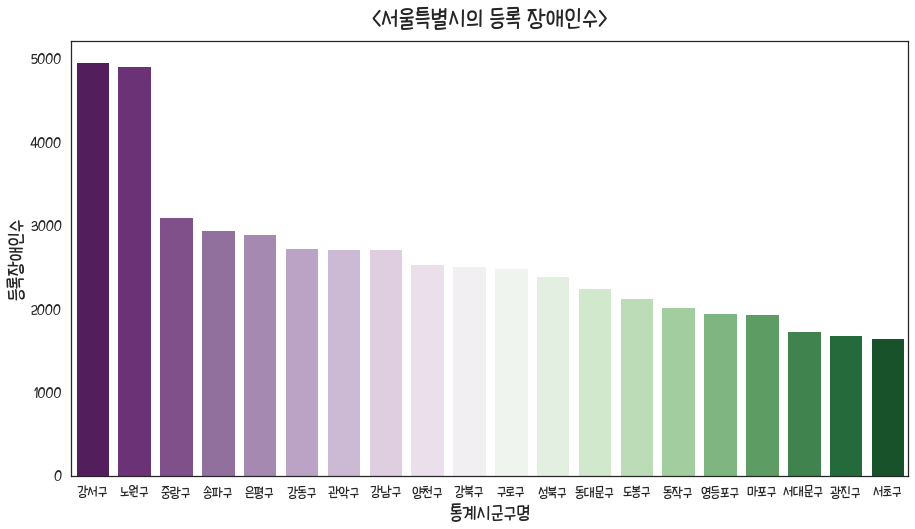

In [210]:
disabled_top20=disabled.sort_values(by='등록장애인수',ascending=False).head(20)
fig = plt.figure(figsize=(15, 8))
# bar그래프 그리기
sns.barplot(x='통계시군구명', y='등록장애인수',palette='PRGn',data=disabled_top20)
plt.xticks(size=15)
plt.yticks(size=15)
plt.xlabel("통계시군구명",size=20)
plt.ylabel("등록장애인수",size=20)
plt.title('<서울특별시의 등록 장애인수>',size=25,pad=15)
plt.savefig("./output/서울특별시의 등록 장애인수.png")

<br><br>
## 승차건수가 가장 많은 동 top20

In [109]:
sns.barplot?

In [171]:
taxi_tmp=call_taxi.groupby(['시/군/구','동/읍/면']).sum().sort_values(by='승차건수',ascending=False).head(20)
taxi_tmp=taxi_tmp.reset_index()
taxi_list=[]
for gu in taxi_tmp['시/군/구'].unique():
    display(taxi_tmp[taxi_tmp['시/군/구']==gu])
    taxi_list.append(taxi_tmp[taxi_tmp['시/군/구']==gu])

,시/군/구,동/읍/면,승차건수
0,노원구,하계1동,13363
2,노원구,상계6.7동,11237
13,노원구,중계2.3동,5681


,시/군/구,동/읍/면,승차건수
1,서대문구,신촌동,13339
14,서대문구,연희동,4954


,시/군/구,동/읍/면,승차건수
3,은평구,역촌동,9233
18,은평구,진관동,4609


,시/군/구,동/읍/면,승차건수
4,마포구,성산제2동,7823
6,마포구,상암동,6663


,시/군/구,동/읍/면,승차건수
5,종로구,이화동,7299


,시/군/구,동/읍/면,승차건수
7,도봉구,도봉제2동,6232


,시/군/구,동/읍/면,승차건수
8,중랑구,신내1동,6155


,시/군/구,동/읍/면,승차건수
9,동작구,신대방제2동,6106


,시/군/구,동/읍/면,승차건수
10,영등포구,여의동,6053


,시/군/구,동/읍/면,승차건수
11,강서구,등촌제3동,5794
12,강서구,가양제2동,5746


,시/군/구,동/읍/면,승차건수
15,송파구,풍납2동,4949


,시/군/구,동/읍/면,승차건수
16,강북구,인수동,4868


,시/군/구,동/읍/면,승차건수
17,관악구,보라매동,4845


,시/군/구,동/읍/면,승차건수
19,양천구,신정3동,4590


In [184]:
sns.barplot?

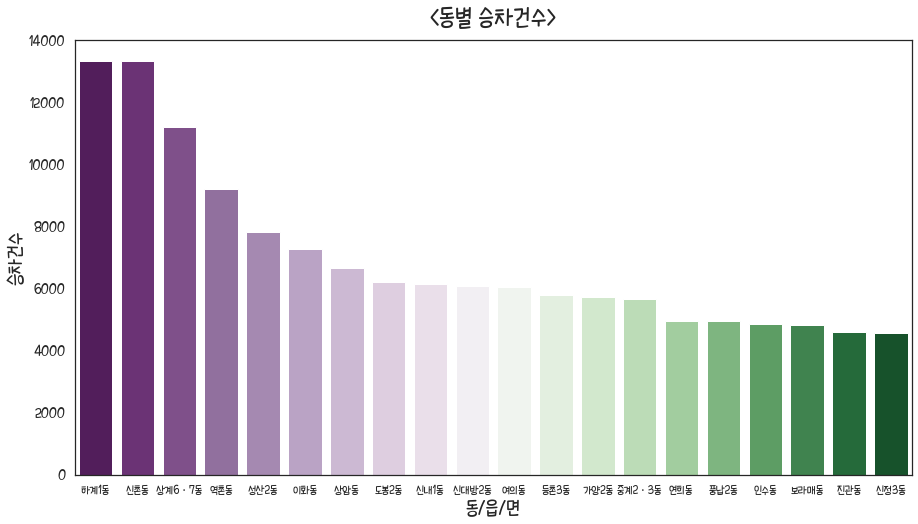

In [211]:
fig = plt.figure(figsize=(15, 8))

# 시별로 범례 만들기
# mycolors=sns.color_palette('Set2',14)
# # bar그래프 그리기
# for data,color in zip(taxi_list,mycolors):   
#     plt.bar(x=data['동/읍/면'],height=data['승차건수'],color=color
#             ,label=data['시/군/구'].iloc[0])
    
taxi_top20=call_taxi_dong.head(20).reset_index()
taxi_top20.rename(columns={'index':'동/읍/면'},inplace=True)
sns.barplot(x='동/읍/면', y='승차건수',palette='PRGn',data=taxi_top20)
plt.xticks(size=12)
plt.yticks(size=15)
plt.xlabel("동/읍/면",size=20)
plt.ylabel("승차건수",size=20)
plt.title('<동별 승차건수>',size=25,pad=15)
plt.savefig("./output/동별 승차건수.png")

In [226]:
plt.ylabel?

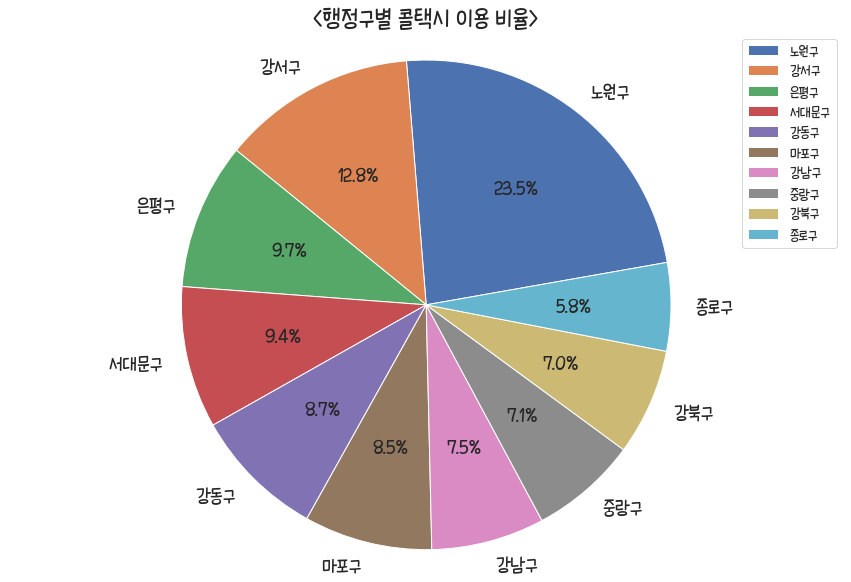

In [227]:
call_taxi_sido=call_taxi[call_taxi['시/도']=='서울특별시']
call_taxi_sido=call_taxi_sido.groupby(['시/군/구']).sum()
call_taxi_sido=call_taxi_sido.sort_values(by='승차건수',ascending=False).head(10)

call_taxi_sido['승차건수'].plot(kind='pie', 
                     figsize=(15, 10),
                     autopct='%1.1f%%',   # 퍼센트 % 표시
                     startangle=10,       # 파이 조각을 나누는 시작점(각도 표시)
                     textprops={'fontsize': 20}
                     )
plt.title('<행정구별 콜택시 이용 비율>', size=25)
plt.axis('equal')    # 파이 차트의 비율을 같게 (원에 가깝게) 조정
plt.legend(labels=call_taxi_sido.index, loc='upper right',fontsize=15)   # 범례 표시
plt.ylabel("",size=20)
plt.savefig("./output/행정구별 콜택시 이용 비율.png")
plt.show()

<br><br><br>
## 장애인수와 휠체어 충전소와의 관계

In [202]:
charger_city=pd.DataFrame(charger.groupby('시군구명').size(),columns=['휠체어충전소개수'])
charger_city=charger_city.reset_index()
charger_city.head()

,시군구명,휠체어충전소개수
0,강남구,25
1,강동구,12
2,강릉시,24
3,강북구,26
4,강서구,33


In [203]:
# 장애인 수 top20와 merge
disable_charger=pd.merge(left=disabled_top20,right=charger_city,how='left',left_on='통계시군구명',right_on='시군구명').fillna(0)
disable_charger=disable_charger[['통계시군구명','등록장애인수','휠체어충전소개수']]
disable_charger['등록장애인수(백 명)']=disable_charger['등록장애인수']/100
disable_charger.head()

,통계시군구명,등록장애인수,휠체어충전소개수,등록장애인수(백 명)
0,강서구,4969,33.0,49.69
1,노원구,4913,39.0,49.13
2,중랑구,3109,0.0,31.09
3,송파구,2950,27.0,29.50
4,은평구,2901,22.0,29.01


In [204]:
left=disable_charger[['통계시군구명','등록장애인수(백 명)']]
left['구분']='등록장애인수(백 명)'
left=left.rename(columns={'등록장애인수(백 명)':'수'})
right=disable_charger[['통계시군구명','휠체어충전소개수']]
right['구분']='휠체어충전소개수'
right=right.rename(columns={'휠체어충전소개수':'수'})
disable_charger=pd.concat([left,right])
disable_charger.head()

C:\Users\won\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\won\anaconda3\envs\pydatavenv\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


,통계시군구명,수,구분
0,강서구,49.69,등록장애인수(백 명)
1,노원구,49.13,등록장애인수(백 명)
2,중랑구,31.09,등록장애인수(백 명)
3,송파구,29.50,등록장애인수(백 명)
4,은평구,29.01,등록장애인수(백 명)


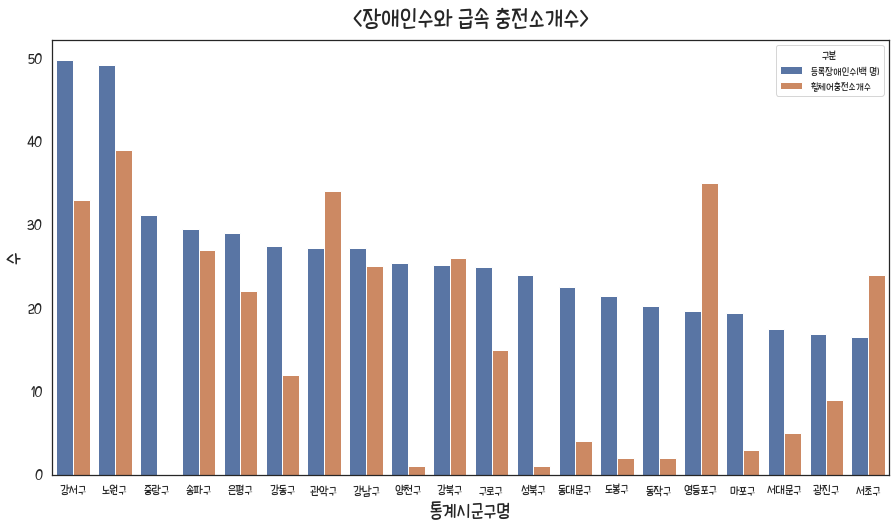

In [207]:
fig = plt.figure(figsize=(15, 8))
# bar그래프 그리기
sns.barplot(x='통계시군구명', y='수',hue='구분',data=disable_charger)
plt.xticks(size=13)
plt.yticks(size=15)
plt.xlabel("통계시군구명",size=20)
plt.ylabel("수",size=20)
plt.title('<장애인수와 급속 충전소개수>',size=25,pad=15)
plt.savefig("./output/장애인수와 급속 충전소개수.png")

<br><br>
## 장애인수 대비 급속 충전소 비율

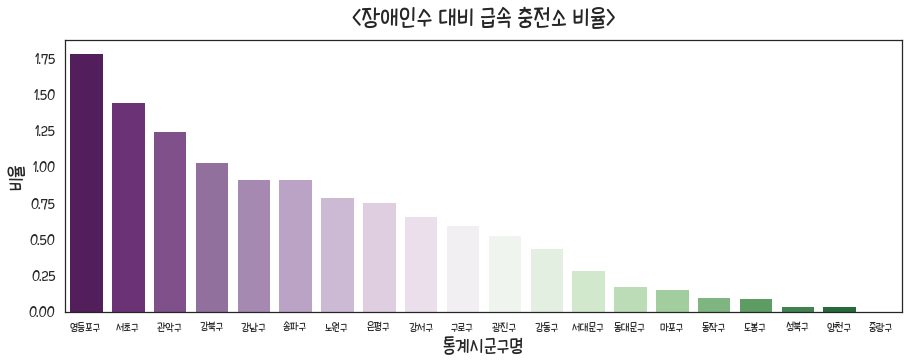

In [212]:
charger_ratio=pd.merge(left=disabled_top20,right=charger_city,how='left',left_on='통계시군구명',right_on='시군구명').fillna(0)
charger_ratio=charger_ratio[['통계시군구명','등록장애인수','휠체어충전소개수']]
charger_ratio['비율']=charger_ratio['휠체어충전소개수']*100/charger_ratio['등록장애인수']
charger_ratio=charger_ratio.sort_values(by='비율',ascending=False)
fig = plt.figure(figsize=(15, 5))
# bar그래프 그리기
sns.barplot(x='통계시군구명', y='비율',palette='PRGn',data=charger_ratio)
plt.xticks(size=12)
plt.yticks(size=15)
plt.xlabel("통계시군구명",size=20)
plt.ylabel("비율",size=20)
plt.title('<장애인수 대비 급속 충전소 비율>',size=25,pad=15)
plt.savefig("./output/장애인수 대비 급속 충전소 비율.png")

<br><br><br>
## 지도 시각화

In [240]:
from folium import plugins
plugins.MarkerCluster?

In [245]:
folium.Choropleth?

In [246]:
# 팝업처리 추가
import pandas as pd
import folium
import json
from folium import plugins

# 경기도 인구변화 데이터를 불러와서 데이터프레임으로 변환
# file_path = './data/total_top100.xlsx'
# df = pd.read_excel(file_path)
# df=df.groupby(['동/읍/면']).sum()
# df.index=city
# df=df.dropna(axis=0)
#df.columns = df.columns.map(str)
#display(call_taxi_dong)
# 경기도 시군구 경계 정보를 가진 geo-json 파일 불러오기
geo_path = './data/new_map.json'
try:
    geo_data = json.load(open(geo_path, encoding='cp949'))
except:
    geo_data = json.load(open(geo_path, encoding='utf-8-sig'))

# 서울 지도 만들기
g_map = folium.Map(location=[37.566345, 126.977893], 
                   tiles='Stamen Terrain', zoom_start=10)



# Choropleth 클래스로 단계구분도 표시하기
aa=folium.Choropleth(geo_data=geo_data,    # 지도 경계
                 data = call_taxi_dong['승차건수'],      # 표시하려는 데이터
                 columns = [call_taxi_dong.index, call_taxi_dong['승차건수']],  # 열 지정
                 fill_color='YlOrRd', fill_opacity=0.7,
                 nan_fill_opacity=0, smooth_factor=0.5,bins=9, legend_name='승차건수',             
                 key_on='feature.properties.name').add_to(g_map)
aa.geojson.add_child(
    folium.features.GeoJsonTooltip(['name'],labels=False)
)

popups = [str(i) for i in range(len(charger_seoul.index))]

locations=[]
# 충전소 위치 클러스터링
for i in charger_seoul.index:
    lat = charger_seoul.loc[i,'위도']
    lng = charger_seoul.loc[i,'경도']
    locations.append([lat,lng])
icons=[]
for i in charger_seoul.index:
    icon = folium.Icon(color='orange', icon='flash')
    icons.append(icon)
plugins.MarkerCluster(locations,icons=icons, popups=popups).add_to(g_map)



# # 충전소 위치 나타내기
# for i in charger_seoul.index:
#     lat = charger_seoul.loc[i,'위도']
#     lng = charger_seoul.loc[i,'경도']
    
#     #추출한 정보를 지도에 표시
#     icon = folium.Icon(color='orange', icon='flash')
#     tooltip=charger_seoul.loc[i,'소재지도로명주소']
#     marker = folium.Marker([lat,lng],icon=icon,tooltip=tooltip)
#     marker.add_to(g_map)

# # 도서관 위치 나타내기
# for i in library.index:
#     lat = library.loc[i,'위도']
#     lng = library.loc[i,'경도']
    
#     #추출한 정보를 지도에 표시
#     icon = folium.Icon(color='blue', icon='book')
#     #tooltip=charger_clean.loc[i,'소재지도로명주소']
#     marker = folium.Marker([lat,lng],icon=icon)
#     marker.add_to(g_map)
    
# # 복지관 위치 나타내기
# for i in welfare.index:
#     lat = welfare.loc[i,'lat']
#     lng = welfare.loc[i,'lng']
    
#     #추출한 정보를 지도에 표시
#     icon = folium.Icon(color='green', icon='leaf')
#     #tooltip=charger_clean.loc[i,'소재지도로명주소']
#     marker = folium.Marker([lat,lng],icon=icon)
#     marker.add_to(g_map)

display(g_map)

In [250]:
!pip freeze

alabaster==0.7.12
anaconda-client==1.7.2
anaconda-navigator==1.9.12
anaconda-project==0.8.3
argh==0.26.2
asn1crypto==1.3.0
astroid @ file:///C:/ci/astroid_1592487315634/work
astropy==4.0.1.post1
atomicwrites==1.4.0
attrs==19.3.0
autopep8 @ file:///tmp/build/80754af9/autopep8_1592412889138/work
Babel==2.8.0
backcall==0.2.0
backports.functools-lru-cache==1.6.1
backports.shutil-get-terminal-size==1.0.0
backports.tempfile==1.0
backports.weakref==1.0.post1
bcrypt==3.1.7
beautifulsoup4==4.9.1
bitarray @ file:///C:/ci/bitarray_1594751093906/work
bkcharts==0.2
bleach==3.1.5
bokeh @ file:///C:/ci/bokeh_1593178781838/work
boto==2.49.0
Bottleneck==1.3.2
brotlipy==0.7.0
certifi==2020.6.20
cffi==1.14.0
chardet==3.0.4
click==7.1.2
cloudpickle @ file:///tmp/build/80754af9/cloudpickle_1594141588948/work
clyent==1.2.2
colorama==0.4.3
comtypes==1.1.7
conda==4.9.1
conda-build==3.18.11
conda-package-handling @ file:///C:/ci/conda-package-handling_1603003327818/work
conda-verify==3.4.2
contextlib2==0.6.0.p